# Datasets Generation

This note book aim to provide function to create, manipulate, and analyze datasets

The dataset is compose a several layers or type of facility/customer mainly represented by there location

In [1]:
import csv
import os

from random import uniform as unif

import networkx as nx

import numpy as np
from numpy import linalg as LA
import scipy as sp
from scipy import stats

import matplotlib as mpl
mpl.use("Agg")  # Must come after importing mpl, but before importing plt
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
out_folder = "./datasets/set1"

In [3]:
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

## Characteristic

A dataset for LRP is a set of several type of entities with a geographic position. Thus we represent it as a dictionary defining each type of entity as following:

```JSON
"Entity Name": {
    "number": integer,
    "coordinate" : string|array,
    "metadata": {
        "color": string|array,
        "size":  string|array,
    }
```


In [4]:
datasets = {
    "lvl1": {
        "number": 25,
        "coordinate" : [(i,j) for i in range(5) for j in range(5)],
        "metadata": {
            "color": ["red" for i in range(25)],
            "size":  [10 for i in range(25)],
        }
    },
    "lvl2": {
        "number": 16,
        "coordinate" : [(i+0.5,j+0.5) for i in range(4) for j in range(4)],
        "metadata": {
            "color": ["green" for i in range(16)],
            "size":  [20 for i in range(16)],
        }
    },
    "lvl3": {
        "number": 9,
        "coordinate" : [(i+1,j+1) for i in range(3) for j in range(3)],
        "metadata": {
            "color": ["blue" for i in range(9)],
            "size":  [30 for i in range(9)],
        }
    }
}

By using strings instead of arrays you signify than you want the given key to be consider has having the same expression for all element. The following example shows an example of short syntax. The function called `expand_short_syntax` define later on can be use to convert the short syntax to a full syntax.

**WARNING:** This is only an idea of prototype, because i didn't solve the dependency injection problem for such representation. For instance, how to provide to the expand syntax, the random number generator that I need.

In [5]:
datasets_short_syntax = {
    "lvl1": {
        "number": 1,
        "coordinate" : "(unif(20,100),unif(20,70))",
        "metadata": {
            "color": "red",
            "size":  10,
        }
    },
    "lvl2": {
        "number": 1,
        "coordinate" : [(unif(20,100),unif(20,70)) for i in range(10)],
        "metadata": {
            "color": "green",
            "size":  20,
        }
    },
    "lvl3": {
        "number": 10,
        "coordinate" : [(unif(20,100),unif(20,70)) for i in range(10)],
        "metadata": {
            "color": ["blue" for i in range(10)],
            "size":  [30 for i in range(5)]+[10 for i in range(5)],
        }
    }
}

In [6]:
def expand_dataset_short_syntax(datasets):
    """
    Given a dataset dictionary using the short syntax. Output the full version
    """
    for dataset in datasets:
        d = datasets[dataset]
        
        if type(d["coordinate"]) is str:
            d["coordinate"] = eval("["+ str(d["coordinate"]) +" for i in range("+ str(d["number"]) +")]")
        
        for metadata in d["metadata"]:
            if type(d["metadata"][metadata]) is str:
                d["metadata"][metadata] = eval("[ \""+ d["metadata"][metadata] +"\" for i in range("+ str(d["number"]) +")]")
            if type(d["metadata"][metadata]) is int:
                d["metadata"][metadata] = eval("["+ str(d["metadata"][metadata]) +" for i in range("+ str(d["number"]) +")]")
            
    return datasets

In [7]:
expand_dataset_short_syntax(datasets_short_syntax)

{'lvl1': {'coordinate': [(20.588443809334454, 47.61538004901344)],
  'metadata': {'color': ['red'], 'size': [10]},
  'number': 1},
 'lvl2': {'coordinate': [(69.55868946241443, 40.96898950676518),
   (69.50723620806514, 52.34072104496674),
   (20.611260982128616, 23.566042667817737),
   (69.8208885891508, 65.31864364517668),
   (87.34878091227107, 60.253888295943646),
   (40.566141682481586, 47.46330201182421),
   (71.74066751146646, 28.28037240729904),
   (45.66350846690458, 54.7460664128852),
   (99.3379299304528, 34.30947392881227),
   (80.03513563788229, 29.70887117047894)],
  'metadata': {'color': ['green'], 'size': [20]},
  'number': 1},
 'lvl3': {'coordinate': [(92.87698712428943, 31.967472979990145),
   (39.304005533711795, 29.6551129761056),
   (95.85327618612966, 58.97634964454753),
   (37.58278105221753, 62.83581147807315),
   (89.62233881462792, 42.607449411736475),
   (97.07927290478762, 63.467787961472645),
   (57.384689059866034, 31.814095889999386),
   (79.23057008689557

## Refactoring data

It is much easier to work with coordinate and distance matrix where entities are sorted according to their coordinates

In [8]:
def sort_coordinates(datasets):
    """
    Sort coordinate of each dataset in increasing order
    """

    for dataset in datasets:
        d = datasets[dataset]

        d["coordinate"] = sorted(d["coordinate"], key=lambda k: [k[0], k[1]])

In [9]:
sort_coordinates(datasets)

# Dataset representation

## Dot Plot

In [24]:
%%file "./helpers/dataset/draw_dataset.py"

import networkx as nx

def draw_dataset(datasets):
    """
    Draw a dot plot of the given dataset
    """
    G = nx.Graph()
    nbr_nodes = 0

    for dataset in datasets:
        d = datasets[dataset]

        for i,xy in enumerate(d["coordinate"]):
            G.add_node(i+nbr_nodes,
               pos=xy,color=d["metadata"]["color"][i],
               size=d["metadata"]["size"][i])

        nbr_nodes += d["number"]

    # Prepare drawing
    pos    = nx.get_node_attributes(G,'pos')
    colors = list(nx.get_node_attributes(G,'color').values())
    size   = list(nx.get_node_attributes(G,'size').values())

    # Draw
    nx.draw_networkx(
        G,pos, node_color=colors,
        node_size=size, with_labels=False
    )
    
    return G

Overwriting ./helpers/dataset/draw_dataset.py


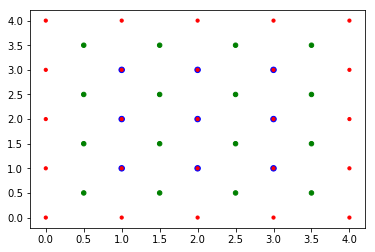

In [11]:
draw_dataset(datasets)

## Distance Matrices

In [22]:
%%file "./helpers/dataset/distance_matrices.py"

import numpy as np
from numpy import linalg as LA

def distance_matrices(datasets):
    """
    Return a dictionary containing all the distance matrices for a
    given instance of the problem
    """
    M = {}

    for dataset1 in datasets:
        d1 = datasets[dataset1]
        for dataset2 in datasets:
            d2 = datasets[dataset2]
            
            M[dataset1+dataset2] = np.zeros((d1["number"],d2["number"]))

            for i,ixy in enumerate(d1["coordinate"]):
                for j,jxy in enumerate(d2["coordinate"]):
                    M[dataset1+dataset2][i][j] = LA.norm(np.subtract(ixy,jxy))
                
    return M

Overwriting ./helpers/dataset/distance_matrices.py


In [13]:
# distance_matrices(datasets)

In [14]:
def distance_matrices_plot(datasets):
    """
        Plot the matrix representation of a dataset
    """
    dist = distance_matrices(datasets)
    len_datasets = len(datasets)
    fig = plt.figure()

    for i,dataset1 in enumerate(datasets):
        for j,dataset2 in enumerate(datasets):
            if j <= i:
                ax = fig.add_subplot(len_datasets,len_datasets,i+len_datasets*j+1)
                ax.set_aspect('equal')
                plt.imshow(dist[dataset2+dataset1], interpolation='nearest')
                if i == len_datasets-1:
                    plt.colorbar()

    plt.show()

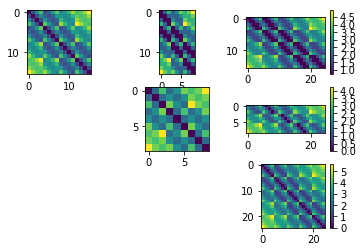

In [15]:
distance_matrices_plot(datasets)

# Dataset Metrics

In [16]:
for i,dataset1 in enumerate(datasets):
    print(dataset1)

lvl2
lvl3
lvl1
